In [71]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster


In [72]:
# Read the CSV file into a DataFrame
df = pd.read_csv('listings_cleaned.csv')
df

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month
0,37.990350,23.730150,Entire home/apt,131,1,1,0.01
1,37.964968,23.721094,Entire home/apt,129,1,1,0.05
2,37.973210,23.734110,Entire home/apt,189,1,1,0.01
3,37.956750,23.729990,Entire home/apt,110,1,1,0.15
4,37.978040,23.721060,Entire home/apt,207,1,1,0.03
...,...,...,...,...,...,...,...
11568,37.990085,23.729179,Entire home/apt,40,7,6,0.64
11569,37.964335,23.742978,Entire home/apt,58,7,1,0.50
11570,37.973880,23.717070,Entire home/apt,80,7,1,0.17
11571,38.009940,23.735890,Entire home/apt,21,7,1,1.00


In [73]:
# One-hot encode the `room_type` column
df = pd.get_dummies(df, columns=['room_type'], prefix='room_type')

In [74]:
 # Select numerical features for clustering
numerical_features = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                      'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']
X = df[numerical_features]


In [75]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [76]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Keep components that explain 95% of variance
X_pca = pca.fit_transform(X_scaled)

In [77]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

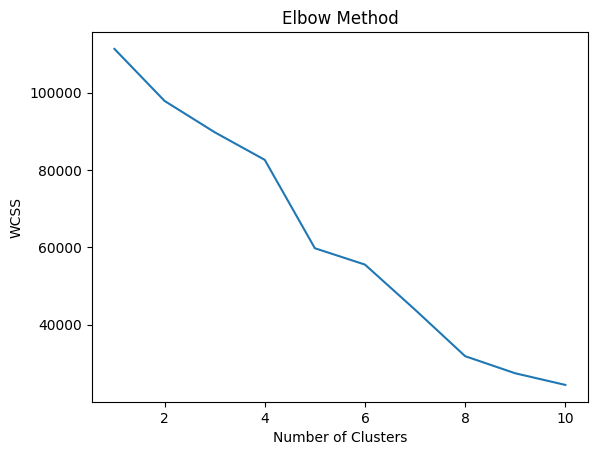

In [78]:
# Plot the elbow method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [79]:
# Apply K-means clustering with the optimal number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_pca)

In [80]:
# Calculate the average values of property attributes for each cluster
cluster_means = df.groupby('cluster')[numerical_features].mean()

# Export cluster_means to Excel
cluster_means.to_excel("cluster_means.xlsx")

In [81]:
# Display the average values in a Markdown table
print(cluster_means.to_markdown(numalign="left", stralign="left"))

| cluster   | latitude   | longitude   | price   | minimum_nights   | number_of_reviews   | reviews_per_month   | room_type_Entire home/apt   | room_type_Hotel room   | room_type_Private room   | room_type_Shared room   |
|:----------|:-----------|:------------|:--------|:-----------------|:--------------------|:--------------------|:----------------------------|:-----------------------|:-------------------------|:------------------------|
| 0         | 37.9893    | 23.7413     | 72.7401 | 3.33739          | 27.2932             | 1.03572             | 0.993683                    | 0                      | 0.00631727               | 0                       |
| 1         | 37.9733    | 23.7254     | 107.961 | 2.16505          | 30.8628             | 1.1789              | 0.881795                    | 0.00711603             | 0.108519                 | 0.00256968              |
| 2         | 37.9759    | 23.7276     | 84.3732 | 1.69063          | 206.6               | 4.39983             

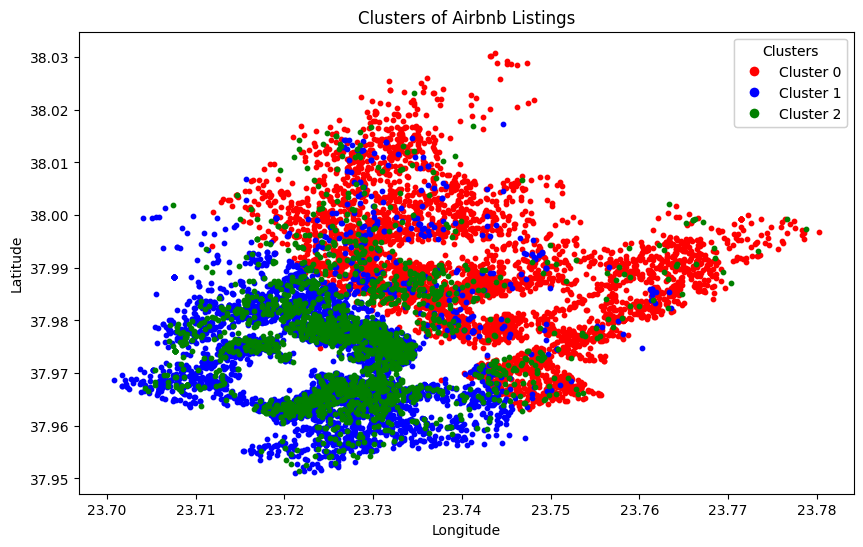

In [82]:
# Create a scatter plot of listings colored by cluster
plt.figure(figsize=(10, 6))
# Define colors for each cluster
colors = ['red', 'blue', 'green']

# Plot each cluster with its corresponding color
for cluster_id in range(3):
    cluster_data = df[df['cluster'] == cluster_id]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], c=colors[cluster_id], label=f'Cluster {cluster_id}', s=10)

plt.title('Clusters of Airbnb Listings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add legend with custom colors
legend_elements = [
    plt.Line2D(df['longitude'], df['latitude'], marker='o', color='w', label='Cluster 0', markerfacecolor='red', markersize=8),
    plt.Line2D(df['longitude'], df['latitude'], marker='o', color='w', label='Cluster 1', markerfacecolor='blue', markersize=8),
    plt.Line2D(df['longitude'], df['latitude'], marker='o', color='w', label='Cluster 2', markerfacecolor='green', markersize=8)
]
legend = plt.legend(handles=legend_elements, title="Clusters")

# Add legend
# legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)

In [83]:
# Create Folium map centered on median latitude/longitude
map_clusters = folium.Map(location=[df['latitude'].median(), df['longitude'].median()], zoom_start=12)
marker_cluster = MarkerCluster().add_to(map_clusters)

In [84]:
color_options = ['red', 'blue', 'green']
cluster_colors = {i: color_options[i % len(color_options)] for i in range(3)}

In [85]:
# Add markers to the map
for _, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Price: ${row['price']}, Min Nights: {row['minimum_nights']}",
        icon=folium.Icon(color=cluster_colors[row['cluster']])
    ).add_to(marker_cluster)

In [86]:
# Save Folium map to an HTML file
map_clusters.save("airbnb_clusters_map.html")

print("Clustering completed! Open 'airbnb_clusters_map.html' to view the map.")

Clustering completed! Open 'airbnb_clusters_map.html' to view the map.
